<a href="https://colab.research.google.com/github/BiancadeFrancisco/Clusterizacao_Kmeans_Wine/blob/main/K_Means_CASE_VINHO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COM UMA DATASET DE DADOS DE DIVERSOS VINHOS, FAZER UMA CLUSTERIZAÇÃO (AGRUPAR EM GRUPOS SIMILARES), COM BASE NAS CARACTERISTICAS DESCRITAS DE CADA UM:

In [ ]:
# BIBLIOTECAS:

# Data wrangling

import numpy as np
import pandas as pd

# Dataviz (VISUALIZAÇÃO DOS DADOS)

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, kelbow_visualizer, silhouette_visualizer

## -- Machine learning -- ##

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.cluster import k_means, dbscan, mean_shift, estimate_bandwidth
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Didatic purposes (FINS DIDÁTICOS)

import string
from ipywidgets import interact

In [ ]:
# CONFIGURAÇÕES PRÉ ESTABELECIDAS DOS GRÁFICOS, PARA AGRADAR E PADRONIZAR ESTÉTICAMENTE: (https://matplotlib.org/stable/tutorials/introductory/customizing.html)

sns.set_theme(
    context='talk', # aplicando no contexto que o tamanho da figura e as letras serão maiores
    style='ticks', # fundo branco
    font_scale=.8, # escala do tamanho de 80%
    palette='tab10', # paleta de cores específica
    rc={
        'figure.figsize': (12,8), # tamanho do gráfico específica
        'axes.grid': True, # terá linhas de fundo
        'grid.alpha': .2, # grau de transparencia 20%
        'axes.titlesize': 'x-large', # título será maior
        'axes.titleweight': 'bold', # título será em negrito
        'axes.titlepad': 20, # espaço entre o gráfico e o título
    }
)

scatter_kwargs = dict(palette='viridis', alpha=0.8, linewidth=0)

# DATASET

In [ ]:
# DATASET VINHOS:

df_wines,_ = datasets.load_wine(as_frame=True, return_X_y=True)

df_wines.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


# DATA CLEANING


In [ ]:
# informações:

df_wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

In [ ]:
# dados nulos?

df_wines.isna().any()

alcohol                         False
malic_acid                      False
ash                             False
alcalinity_of_ash               False
magnesium                       False
total_phenols                   False
flavanoids                      False
nonflavanoid_phenols            False
proanthocyanins                 False
color_intensity                 False
hue                             False
od280/od315_of_diluted_wines    False
proline                         False
dtype: bool

In [ ]:
# dados duplicados?

df_wines.duplicated().any()

False

# VERIFICAR OUTLIERS

In [ ]:
# COLOCAR DADOS NA MESMA ESCALA:

df_wines_scaled = df_wines.apply(scale)

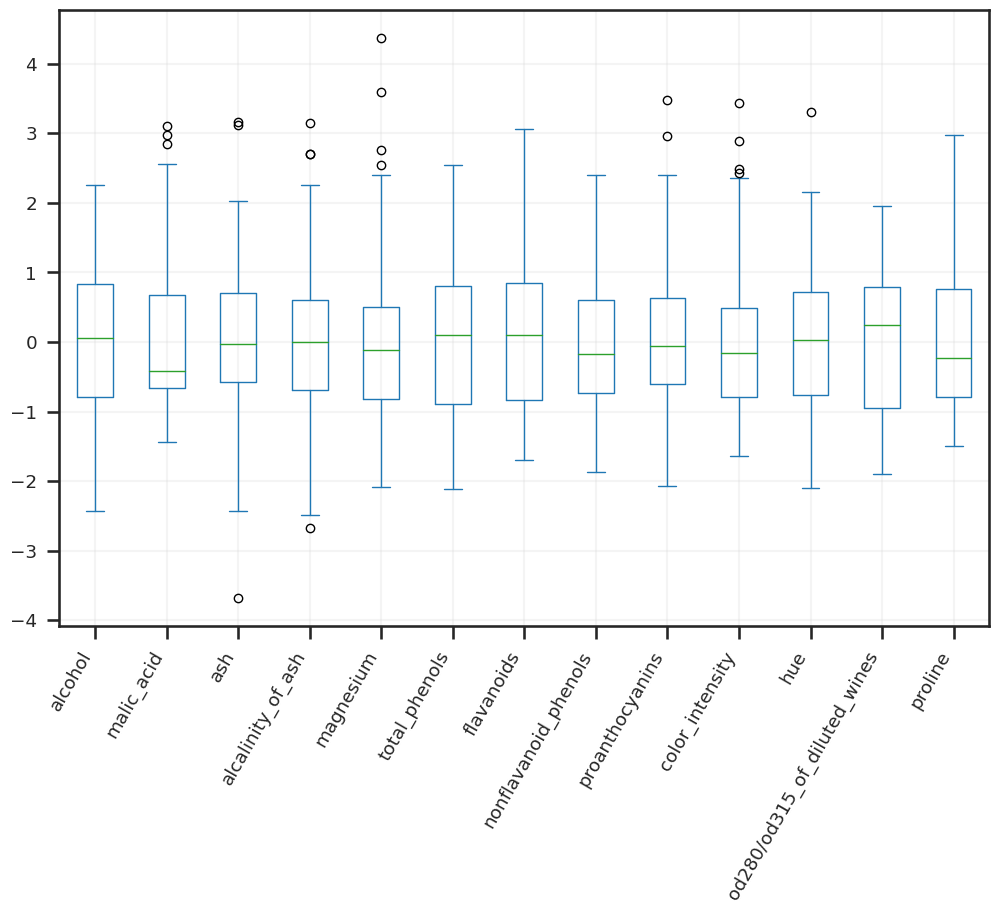

In [ ]:
# PLOTAR GRÁFICO COM DADOS ESCALAS, PARA VERIFICAR OUTLIERS:

df_wines_scaled.plot.box()
plt.xticks(rotation=60, ha='right');

In [ ]:
# Identificando e removendo linhas com outliers (|Z-score| > 3):

outlier_rows = df_wines_scaled.abs().gt(3).any(axis=1)  # ABS = (APENAS VALORES ABSOLUTOS), GT = (|Z-score| >), any(axis=1) = (SE NA LINHA EXISTE VALOR MAIOR QUE ZERO)
outlier_rows.sum()  # TENHO 10 OUTLIERS ACIMA DE 3 OU -3

10

In [ ]:
df_wines_scaled = df_wines_scaled[~outlier_rows] # TIRAR TODOS ESSES OUTLIERS ([~outlier_rows]) DO DATASET JÁ ESCALADO

# CLUSTERIZAÇÃO

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

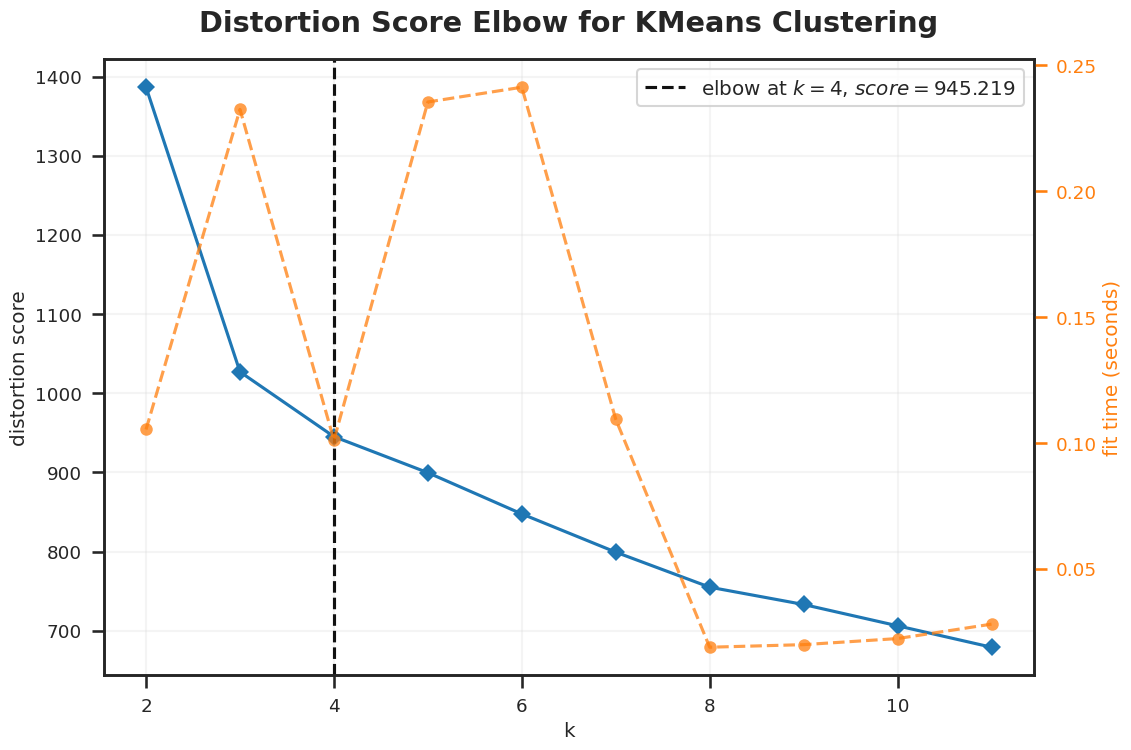

In [ ]:
# ENCONTRANDO MELHOR K:

kelbow_visualizer(KMeans(), df_wines_scaled, k=11);   # SUGERIDO PELO MODELO: K = 4 (iremos dividir em 4 grupos com caracteristicas similares)

In [ ]:
# CRIANDO O MODELO DE CLUSTERIZAÇÃO:

model = KMeans(4, random_state=0).fit(df_wines_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# SALVANDO CENTRÓIDES E LABELS:

centroids = model.cluster_centers_
labels = model.labels_

In [ ]:
# VISUALIZANDO OS CENTRÓIDES DOS 4 GRUPOS:

pd.DataFrame(centroids, columns=df_wines_scaled.columns).T.add_prefix('Grupo_')  # T = transpose, add_prefix('Grupo_') = colocar nome das colunas de cada grupo (clusters)

,Grupo_0,Grupo_1,Grupo_2,Grupo_3
alcohol,0.146964,0.960537,-0.974152,-0.786132
malic_acid,0.937031,-0.316354,-0.395284,-0.453349
ash,0.195499,0.309729,0.191113,-0.790481
alcalinity_of_ash,0.528549,-0.774933,0.648933,-0.143883
magnesium,-0.076428,0.455725,-0.490200,-0.549105
total_phenols,-1.026817,0.897698,-0.628614,0.265048
flavanoids,-1.237424,0.974760,-0.367120,0.316454
nonflavanoid_phenols,0.700397,-0.607763,0.797288,-0.502648
proanthocyanins,-0.816473,0.563785,-0.495663,0.255705
color_intensity,0.903750,0.241598,-0.916222,-0.806486


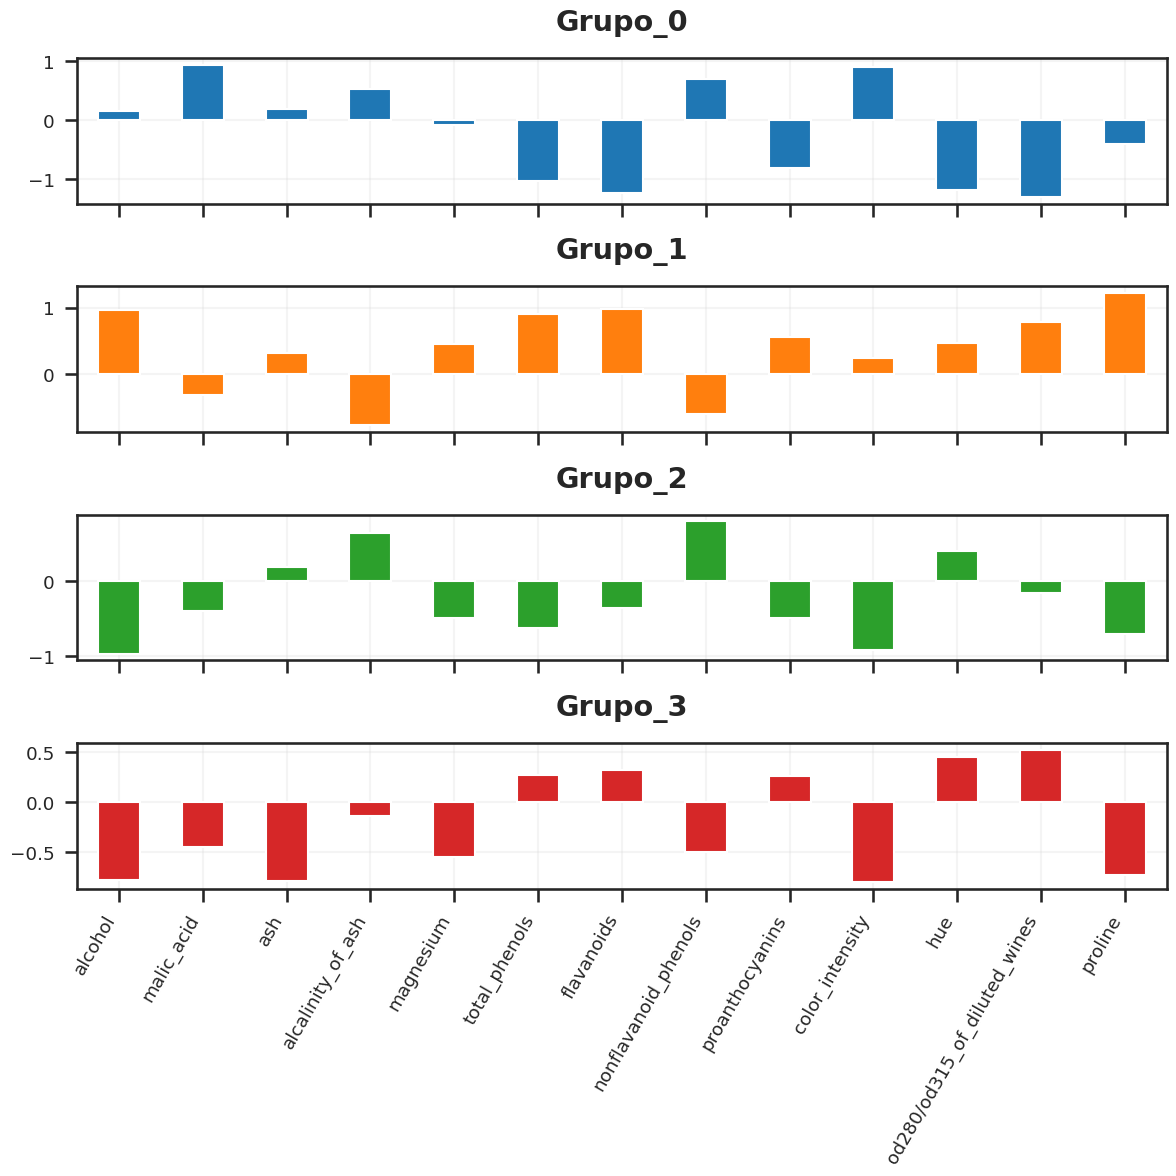

In [ ]:
# INTERPRETANDO CLUSTERS COM GRÁFICO:

(
  pd.DataFrame(centroids, columns=df_wines_scaled.columns)
  .T.add_prefix('Grupo_')
  .plot.bar(subplots=True, figsize=(12,12), legend=False) # dividir o gráfico de barras em subplots
)

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
centers = pd.DataFrame(centroids, columns=df_wines.columns)
centers

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.146964,0.937031,0.195499,0.528549,-0.076428,-1.026817,-1.237424,0.700397,-0.816473,0.903750,-1.179659,-1.296928,-0.398762
1,0.960537,-0.316354,0.309729,-0.774933,0.455725,0.897698,0.974760,-0.607763,0.563785,0.241598,0.463243,0.786065,1.220968
2,-0.974152,-0.395284,0.191113,0.648933,-0.490200,-0.628614,-0.367120,0.797288,-0.495663,-0.916222,0.401839,-0.154359,-0.709675
3,-0.786132,-0.453349,-0.790481,-0.143883,-0.549105,0.265048,0.316454,-0.502648,0.255705,-0.806486,0.453388,0.521338,-0.734021


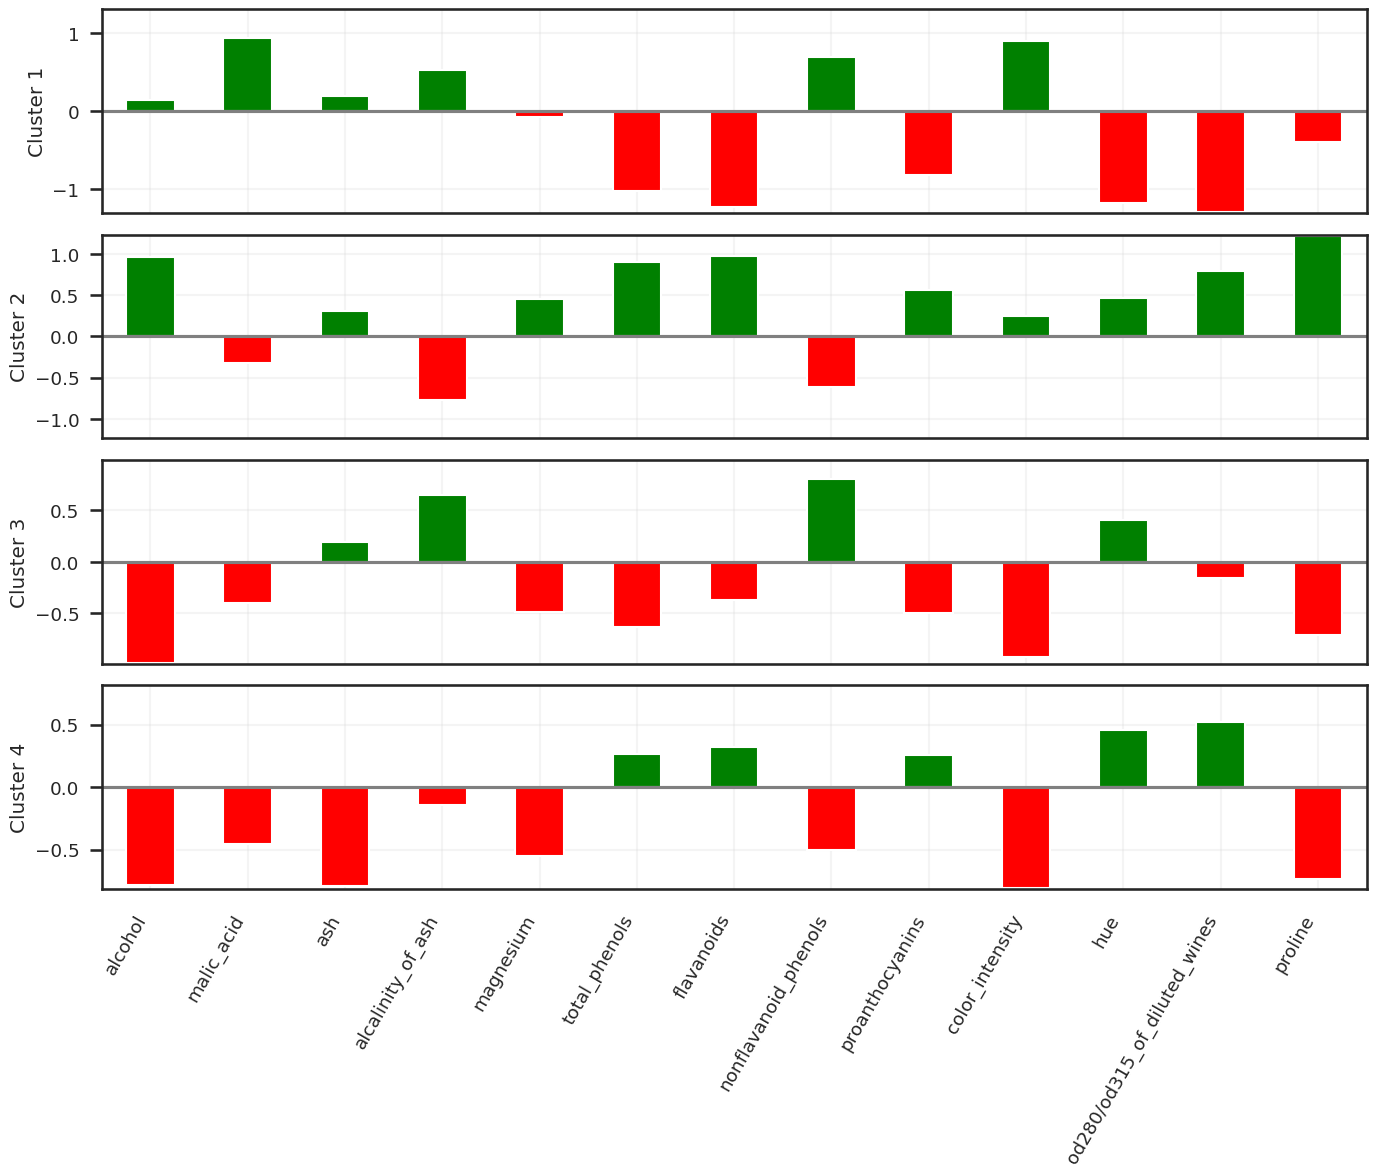

In [ ]:
# INTERPRETANDO CLUSTERS COM GRÁFICO - Adaptado do livro "Practical Statistics for Data Scientists", cap Cluster, método k-means:

fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# INTERPRETANDO CLUSTERS COM TABELA

(
  df_wines[~outlier_rows].assign(cluster=labels)
  .groupby('cluster')
  .agg(['mean','min','median','max'])
)

alcohol                       malic_acid                     \
              mean    min  median    max       mean   min median   max   
cluster                                                                  
0        13.119592  12.20  13.110  14.16   3.380204  1.24  3.300  5.65   
1        13.778214  12.85  13.765  14.83   1.983929  1.35  1.765  4.04   
2        12.212000  11.41  12.080  13.49   1.896000  0.74  1.630  4.43   
3        12.364211  11.45  12.335  13.86   1.831316  0.89  1.520  4.31   

              ash        ...    hue       od280/od315_of_diluted_wines        \
             mean   min  ... median   max                         mean   min   
cluster                  ...                                                   
0        2.420000  1.98  ...  0.670  0.96                     1.693469  1.27   
1        2.451250  2.04  ...  1.065  1.28                     3.168214  2.51   
2        2.418800  2.02  ...  0.980  1.45                     2.502400  1.59   
3        2.150263  1.70  ...  1.060  1.42                     2.980789  2.14   

                          proline                         
        median   max         mean    min  median     max  
cluster                                                   
0        1.680  2.47   621.673469  372.0   620.0   880.0  
1        3.170  4.00  1130.303571  735.0  1100.0  1680.0  
2        2.500  3.30   524.040000  315.0   495.0   870.0  
3        3.035  3.64   516.394737  278.0   479.0  1020.0  

[4 rows x 52 columns]

In [ ]:
# INTERPRETANDO CLUSTERS COM TABELA

(
  df_wines[~outlier_rows].assign(cluster=labels)
  .groupby('cluster')
  .mean()
  .transpose()
)

cluster,0,1,2,3
alcohol,13.119592,13.778214,12.21200,12.364211
malic_acid,3.380204,1.983929,1.89600,1.831316
ash,2.420000,2.451250,2.41880,2.150263
alcalinity_of_ash,21.255102,16.914286,21.65600,19.015789
magnesium,98.653061,106.232143,92.76000,91.921053
total_phenols,1.654286,2.855357,1.90280,2.460526
flavanoids,0.796735,3.000179,1.66360,2.344474
nonflavanoid_phenols,0.448776,0.286429,0.46080,0.299474
proanthocyanins,1.124898,1.912679,1.30800,1.736842
color_intensity,7.147347,5.616607,2.94000,3.193684


In [ ]:
# INTERPRETANDO CLUSTERS COM TABELA ESTILIZADA

(
  df_wines[~outlier_rows].assign(cluster=labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)


# interpretando: por exemplo, o vinho que tem mais teor alcóolico é do grupo 1, o vinho com maior intensidade de cor é do grupo 0, etc...

cluster,0,1,2,3
alcohol,13.119592,13.778214,12.212000,12.364211
malic_acid,3.380204,1.983929,1.896000,1.831316
ash,2.420000,2.451250,2.418800,2.150263
alcalinity_of_ash,21.255102,16.914286,21.656000,19.015789
magnesium,98.653061,106.232143,92.760000,91.921053
total_phenols,1.654286,2.855357,1.902800,2.460526
flavanoids,0.796735,3.000179,1.663600,2.344474
nonflavanoid_phenols,0.448776,0.286429,0.460800,0.299474
proanthocyanins,1.124898,1.912679,1.308000,1.736842
color_intensity,7.147347,5.616607,2.940000,3.193684


In [ ]:
# VERIFICANDO A MÉTRICA:

silhouette_score(df_wines_scaled[~outlier_rows], labels)

# quantifica a qualidade do agrupamento alcançado - portanto, você deve selecionar o número de clusters que maximiza o coeficiente da silhueta.

<ipython-input-20-cb769b07a8aa>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  silhouette_score(df_wines_scaled[~outlier_rows], labels)


0.24989859662052233